# Импорт необходимых модулей

In [1]:
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import semantic_search
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

%matplotlib inline

In [3]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import models, losses
from sentence_transformers import LoggingHandler, InputExample
from sentence_transformers.evaluation import BinaryClassificationEvaluator

In [4]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import re
from gensim.models import word2vec
import gensim.downloader

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')
drive_data_dir = '/content/drive/MyDrive/Colab Notebooks/vkr/'

Mounted at /content/drive


## Подключим классификатор идиоматических/буквальных текстов

In [ ]:
!git clone 'https://github.com/zzeng13/DISC' disc_repo

Cloning into 'disc_repo'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 58 (delta 1), reused 4 (delta 1), pack-reused 49
Unpacking objects: 100% (58/58), 84.38 MiB | 5.47 MiB/s, done.
Updating files: 100% (40/40), done.


In [ ]:
%cd /content/disc_repo

/content/disc_repo


In [ ]:
from IPython.display import display, HTML
import torch
import numpy as np
from tqdm import tqdm
from src.utils.model_util import load_model_from_checkpoint
from src.model.read_comp_triflow import ReadingComprehensionDetector as DetectorMdl
from config import Config as config
from demo_helper.data_processor import DataHandler
from demo_helper.visualize_helper import simple_scoring_viz

In [ ]:
%mkdir ./checkpoints

In [ ]:
%cp /content/drive/MyDrive/Colab\ Notebooks/vkr/checkpoints.zip /content/disc_repo/checkpoints

In [ ]:
!unzip /content/disc_repo/checkpoints/checkpoints.zip -d /content/disc_repo/checkpoints/

Archive:  /content/disc_repo/checkpoints/checkpoints.zip
   creating: /content/disc_repo/checkpoints/checkpoints/
  inflating: /content/disc_repo/checkpoints/checkpoints/ReadComp_magpie_random_cross_attn-glove-char-pos-tri_latest.mdl  


In [ ]:
%cp /content/disc_repo/checkpoints/checkpoints/ReadComp_magpie_random_cross_attn-glove-char-pos-tri_latest.mdl /content/disc_repo/checkpoints

In [ ]:
data_handler = DataHandler(config)
detector_model= load_model_from_checkpoint(DetectorMdl, data_handler.config)

Loading Pre-trained Glove Embeddings...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero

Loading model from /content/disc_repo/checkpoints/ReadComp_magpie_random_cross_attn-glove-char-pos-tri_latest.mdl
=> loading checkpoint '/content/disc_repo/checkpoints/ReadComp_magpie_random_cross_attn-glove-char-pos-tri_latest.mdl'
=> loaded checkpoint '/content/disc_repo/checkpoints/ReadComp_magpie_random_cross_attn-glove-char-pos-tri_latest.mdl'


In [ ]:
%cd ..

/content


# Предобработка датасета

In [6]:
# подгрузим идиомы с IBM Debater
debator_df = pd.read_csv(os.path.join(drive_data_dir, 'debator_idioms.tsv'), sep='\t')
print(debator_df.Idiom.nunique(), 'уникальных идиом')
debator_df.head()

5000 уникальных идиом


,Idiom,WiktionaryURL,Pos,Neg,Neu,Inapprop.,Total,%Pos,%Neg,%Neu,Maj. Label,FilterOut(X)
0,American Dream,https://en.wiktionary.org/wiki/American_Dream,8,0,2,0,10,0.8,0.0,0.2,positive,NaN
1,Catch-22,https://en.wiktionary.org/wiki/Catch-22,0,7,3,0,10,0.0,0.7,0.3,negative,NaN
2,Christmas present,https://en.wiktionary.org/wiki/Christmas_present,6,0,4,0,10,0.6,0.0,0.4,positive,NaN
3,Downing Street,https://en.wiktionary.org/wiki/Downing_Street,0,0,10,0,10,0.0,0.0,1.0,neutral,NaN
4,Dutch courage,https://en.wiktionary.org/wiki/Dutch_courage,2,2,6,0,10,0.2,0.2,0.6,neutral,NaN


*ниже закоменчен код для создания датафрейма с уникальными статическими идиомами из epie*

In [ ]:
# epie_idioms = []
# with open('/content/Static_idioms.txt') as f:
#   for line in f:
#     line = line.strip()
#     if line in epie_idioms:
#       print(line)
#     else:
#       epie_idioms.append(line)

# epie_idioms_df = pd.DataFrame({'idioms': epie_idioms})
# epie_idioms_df.to_csv('unique_idioms_epie.csv', index=False)

In [7]:
# подгрузим уникальные статические идиомы из датасета epie
epie_idioms_df = pd.read_csv(os.path.join(drive_data_dir, 'unique_idioms_epie.csv'))
print(epie_idioms_df.idioms.nunique(), 'уникальных идиом')
epie_idioms_df.head()

359 уникальных идиом


,idioms
0,just in case
1,a sorry sight
2,rule of thumb
3,carpe diem
4,salad days


Добавим определения

In [8]:
definitions_dict = {}
definitions_lst = []

with open(os.path.join(drive_data_dir, 'Static_idioms_meanings.txt'), 'r') as definitions_file:
  for i, line in enumerate(definitions_file):
    definitions_lst.append(line)
    if '<div class="ds-list">' in line:
      div_lst = BeautifulSoup(line, 'html.parser').findAll('div', class_='ds-list')
      for tag in div_lst:
        if tag.span is not None:
          tag.span.decompose()
      definitions_dict[epie_idioms_df.idioms.loc[i]] = ' '.join([x.text for x in div_lst])
    else:
      try:
        definitions_dict[epie_idioms_df.idioms.loc[i]] = line.strip().split('>')[1].split('<')[0].strip()
      except:
        print(epie_idioms_df.idioms.loc[i])
        definitions_dict[epie_idioms_df.idioms.loc[i]] = ''

open warfare
hold on a second
stranger things have happened
way around
dead right
fancy free
well read
all together now
ring fencing
technically speaking
all the more
behave yourself
self explanatory
no rush


Добавим определения для идиом, которые или отсутствуют в списке с определениями, или при парсинге не удалось найти определение

In [9]:
# для первых 2-х не было определения, для остальных определения не нашлись,
# скорее всего, т.к. определения были во вложенных тегах (вида <i>slang</i>)
definitions_dict['hold on a second'] = 'Wait a short while.'
definitions_dict['way around'] = 'Find an alternative for something, someone or to perform a task. Find a solution.'
definitions_dict['no spring chicken'] = 'Someone well past youth; an old person.'
definitions_dict['an arm and a leg'] = 'Very expensive; costing a lot of money.'
definitions_dict['a sight for sore eyes'] = 'Someone or something that one is excited or overjoyed to see, often after a long absence or separation.'

In [10]:
epie_idioms_df['definitions'] = epie_idioms_df['idioms'].apply(lambda x: definitions_dict[x])

In [ ]:
# epie_idioms_df.to_csv(os.path.join(drive_data_dir, 'epie_idioms_with_definitions.csv'), index=False)

# Пересечение идиом Debater и EPIE

In [11]:
# epie_idioms_df = pd.read_csv(os.path.join(drive_data_dir, 'epie_idioms_with_definitions.csv'))
epie_idioms_df.head(5)

,idioms,definitions
0,just in case,In the event that something does or does not h...
1,a sorry sight,"Someone or something that has a piteous, woefu..."
2,rule of thumb,An approximation; a suggested method or guidel...
3,carpe diem,"Enjoy and make the most of the present, especi..."
4,salad days,"A youthful, carefree time of innocence and ine..."


In [ ]:
len(set(epie_idioms_df.idioms.unique()).intersection(set(debator_df.Idiom.str.lower().unique())))

147

In [11]:
dif = list(set(epie_idioms_df.idioms.unique()) - set(debator_df.Idiom.str.lower().unique()))

In [13]:
for idiom in dif:
  if len(debator_df[debator_df.Idiom.str.lower().str.contains(idiom[2:])]) > 0:
    print(idiom)

per se
rest up
way around
a slap on the wrist
a fish out of water
a flash in the pan
a blessing in disguise
against time
all the way
a red flag
pin money
a sea change
a shot in the arm
a foot in the door
a steal
to this day
to a fine art
thumbs up
icing on the cake
at hand
a fly on the wall
a sight for sore eyes
a breath of fresh air


Точно исключаем из разности следующие идиомы, поскольку они встречаются так же и в debater, просто строковое совпадение не совсем точное:  
1. (race) against time  
2. shot in the arm  
3. breath of fresh air  
4. (get one's) foot in the door  
5. (go) all the way  
6. (the) icing on the cake	 
7. fly on the wall  
8. (down) to a fine art  
9. sea change  
10. flash in the pan  
11. blessing in disguise  
12. slap on the wrist  
13. (two) thumbs up  
14. sight for sore eyes  
15. fish out of water  
16. (know one's/long) way around   
17. red flag

In [12]:
def del_from_lst(lst1, lst2):
    for i in lst2:
        if i in lst1:
            lst1.pop(lst1.index(i))
        else:
            print(f'{i} not in the list to delete from')

del_from_dif = ['against time', 'a shot in the arm', 'a breath of fresh air',
                'a foot in the door', 'all the way', 'icing on the cake', 
                'a fly on the wall', 'to a fine art', 'a sea change', 
                'a flash in the pan', 'a blessing in disguise', 'a slap on the wrist',
                'thumbs up', 'a sight for sore eyes', 'a fish out of water', 
                'way around', 'a red flag']
del_from_lst(dif, del_from_dif)

Используем меру Жаккара (IoU), чтобы отловить ещё возможные пересечения

In [13]:
def sets_jaccar(set1, set2):
    return len(set1 & set2) / len(set1 | set2) 

In [14]:
def iou(epie_idiom):
    l = []
    for debater_idiom in debator_df.Idiom:
        set_debator_idiom = set(debater_idiom.split())
        set_epie_idiom = set(epie_idiom.split())
        l.append(tuple([debater_idiom, sets_jaccar(set_debator_idiom, set_epie_idiom)]))
    l = sorted(l, key=lambda x: x[1], reverse=True)[:3]
    return [i[0] for i in l if i[1] > 0]

In [ ]:
epie_idioms_df['closest_by_jaccar'] = epie_idioms_df.idioms.apply(iou)
epie_idioms_df['len'] = epie_idioms_df.closest_by_jaccar.apply(lambda x: len(x))

In [ ]:
epie_idioms_df[epie_idioms_df['len'] == 0]

,idioms,definitions,closest_by_jaccar,len
3,carpe diem,"Enjoy and make the most of the present, especi...",[],0
84,nitty gritty,"The specific facts, details, or elements of so...",[],0
158,mea culpa,An admission or expression of guilt or persona...,[],0
163,familiarity breeds contempt,Repeated exposure to someone or something ofte...,[],0
182,building blocks,,[],0
192,al fresco,"Outside in the fresh air. ""Al fresco"" is Itali...",[],0
198,technically speaking,,[],0
217,per se,by or in itself; intrinsically,[],0
256,mumbo jumbo,"Speech or writing that is nonsensical, overly ...",[],0
267,ill-gotten gains,"Something, often money, that has been obtained...",[],0


In [ ]:
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = None

In [ ]:
epie_idioms_df[epie_idioms_df['idioms'].isin(dif) & epie_idioms_df['len'] > 0][['idioms', 'closest_by_jaccar']]

,idioms,closest_by_jaccar
1,a sorry sight,"[not a pretty sight, do a, nary a]"
4,salad days,"[for days, halcyon days, bad old days]"
5,off the record,"[off the bat, off the chain, off the grid]"
6,thank goodness,"[my goodness, oh my goodness, thank one's lucky stars]"
8,dog days,"[dog around, dog eat dog, dog it]"
11,an arm and a leg,"[arm and a leg, break a leg, shake a leg]"
14,close call,"[call on, call out, call up]"
16,open warfare,"[class warfare, open book, open doors]"
17,pin money,"[Monopoly money, dirty money, even money]"
18,third time lucky,"[about time, borrowed time, buy time]"


Следующие идиомы также фактически присутствуют в debater, что получилось установить с помощью меры Жакара (в скобках указана их форма, в которой они фигурируют в debater)
1. an arm and a leg	(arm and a leg)
2. hold on a second	(hold on)
3. dressed up to the nines (dressed to the nines)
4. baptism of fire (baptism by fire)
5. hold your horses (hold one's horses)
6. the best of both worlds (best of both worlds)
7. fall for it (fall for)
8. the upper crust (upper crust)
9. an eye for an eye (eye for an eye)
10. the last straw (last straw)
11. come rain or shine (rain or shine)
12. not in a million years (never in a million years)

In [15]:
del_from_dif1 = ['an arm and a leg', 'hold on a second', 'dressed up to the nines', 
                 'baptism of fire', 'hold your horses', 'the best of both worlds',
                 'fall for it', 'the upper crust', 'an eye for an eye',
                 'the last straw', 'come rain or shine', 'not in a million years']

In [16]:
del_from_lst(dif, del_from_dif1)

In [17]:
len(dif)

183

Итоговое пересечение по идиомам: 176/359

*ниже закоменчен код для создания датафрейма с примерами предложений для статических идиом из epie*

In [ ]:
# epie_label_idioms = []
# epie_sentences = []
# with open('/content/Static_Idioms_Candidates.txt') as f1, open('/content/Static_Idioms_Words.txt') as f2:
#   for line in f1:
#     epie_label_idioms.append(line.strip())
#   for line in f2:
#     epie_sentences.append(line.strip())

# epie_dataset_df = pd.DataFrame({'idiom_label': epie_label_idioms,
#                                 'sentence': epie_sentences})
# epie_dataset_df.to_csv('epie_dataset.csv', index=False)

In [ ]:
pd.reset_option('display.max_colwidth')

## Загрузка датасета с идиомами и примерами предложений

In [18]:
epie_dataset_df = pd.read_csv(os.path.join(drive_data_dir, 'epie_dataset.csv'))
epie_dataset_df.head()

,idiom_label,sentence
0,keep up the good work,"Anyway , thanks MKM and keep up the good work !"
1,keep up the good work,Well done Steffi — keep up the good work and k...
2,keep up the good work,Please use it as a reminder to ensure that you...
3,keep up the good work,Please do keep up the good work .
4,keep up the good work,We hope you find the current issue still of in...


In [19]:
epie_dataset_df.shape[0]

21891

In [20]:
epie_dataset_df_intersect = epie_dataset_df[~epie_dataset_df['idiom_label'].isin(dif)]
# epie_dataset_df_rest = epie_dataset_df[epie_dataset_df['idiom_label'].isin(dif)]

# Используем классификатор идиоматический/буквальный

In [ ]:
sentences = epie_dataset_df_intersect.sentence.to_list()

In [ ]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [ ]:
len(sentences)

15176

In [ ]:
data = data_handler.prepare_input(sentences[:(len(sentences) // 1000)])
# data = data_handler.prepare_input(sentences[(len(sentences) // 3): 2 * (len(sentences) // 3)])
# data = data_handler.prepare_input(sentences[2 * (len(sentences) // 3):])

In [ ]:
data['xs_bert'].shape

torch.Size([15, 112])

In [ ]:
import pickle 

# with open('partition1.pkl', 'wb') as f:
# with open('partition2.pkl', 'wb') as f:
with open('partition3.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# %cp /content/partition1.pkl /content/drive/MyDrive/Colab\ Notebooks/vkr/
# %cp /content/partition2.pkl /content/drive/MyDrive/Colab\ Notebooks/vkr/
%cp /content/partition3.pkl /content/drive/MyDrive/Colab\ Notebooks/vkr/

In [ ]:
with torch.no_grad():
    ys_ = detector_model(data)
    probs = torch.nn.functional.softmax(ys_, dim=-1)
ys_ = ys_.cpu().detach().numpy()
probs = probs.cpu().detach().numpy()
idiom_class_probs = probs[:, :, -1].tolist()
predicts = np.argmax(ys_, axis=2)

In [ ]:
sentences_tkns = data['xs_bert'].cpu().detach().numpy().tolist()
sentences_tkns = [data_handler.tokenizer.convert_ids_to_tokens(s) for s in sentences_tkns]

In [ ]:
for s in sentences_tkns:
  print(s)

['[CLS]', '‘', 'he', 'would', 'not', 'have', 'harmed', 'a', 'fly', 'never', 'mind', 'murdering', 'a', 'young', 'woman', '.', '’', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', '‘', 

In [ ]:
for i in range(len(sentences_tkns)):
    s = simple_scoring_viz(sentences_tkns[i], idiom_class_probs[i], 'YlGn')
    print(idiom_class_probs[i])
    print(sentences[i])
    display(HTML(s))

[5.74943754796772e-18, 1.5995836382884376e-12, 1.8457983752551144e-10, 2.1066716371365146e-08, 5.289125937224526e-08, 8.77843206126272e-07, 0.9999947547912598, 0.999996542930603, 0.9999903440475464, 0.04017291218042374, 0.413892537355423, 1.0062620958706248e-06, 5.639743339003189e-09, 1.3074810567559325e-08, 8.539631579651541e-08, 3.736458364933526e-11, 2.3060555201515065e-12, 3.1958807974930995e-20, 3.944425081697789e-12, 3.785429192326717e-10, 8.72600713908156e-10, 3.3096232421314653e-09, 6.515213368807338e-10, 1.3745666826991965e-09, 7.166067184094516e-10, 8.864762257587699e-10, 2.1593928034580046e-10, 8.55265094856783e-11, 1.2647942415622282e-10, 1.922664388809281e-10, 3.8007175184873176e-10, 7.912361876805107e-10, 1.0857806875819165e-09, 2.663231413180256e-09, 1.674915139915356e-08, 2.8351558967187884e-07, 3.443264873226326e-08, 7.992780659549226e-09, 1.873198485213834e-09, 1.504355390258283e-10, 8.29441584859758e-11, 8.869749379414316e-11, 1.8096422138569324e-09, 2.60349652947411

[2.22793256318951e-17, 4.459951071650314e-12, 3.019597766273918e-11, 1.9200992185108845e-10, 3.287486394221162e-10, 1.2526207848750914e-09, 9.528433597694175e-10, 4.975382883465329e-10, 9.265638950539667e-11, 1.684562628279096e-10, 1.8432979587146292e-09, 5.386222579062405e-10, 1.126464546641337e-10, 1.8779918065092716e-08, 6.873975832988322e-10, 5.484866449911863e-10, 3.234896155390743e-07, 2.164555183981065e-07, 1.2677613767664297e-06, 1.0530047802603804e-06, 8.795418011686706e-07, 2.3606105958862145e-09, 1.9286586216971102e-10, 6.672592339773686e-11, 3.9528544326650206e-10, 1.3306311608118904e-09, 1.92194682391289e-09, 1.8443589711036878e-10, 8.110266347394202e-10, 7.945878954807029e-10, 3.820979088686727e-09, 9.134306644398293e-09, 4.3668450189215946e-08, 3.371437884425177e-08, 2.5407819848055624e-08, 0.9983186721801758, 0.9911467432975769, 0.9843745827674866, 7.784340994021477e-08, 4.932263322741134e-16, 4.380931728498183e-10, 1.2142958638605705e-08, 7.601683904567835e-08, 3.85267

[6.944199440356143e-18, 0.1584329754114151, 0.7837061285972595, 0.5969781875610352, 0.9999990463256836, 0.9999499320983887, 4.2441484993105405e-08, 2.165458523199136e-16, 9.887559659915723e-10, 7.051648509559527e-08, 2.112693238132124e-07, 6.421685611712746e-06, 4.076906407135539e-06, 4.285951490601292e-06, 2.9518199085032393e-07, 8.170750334102195e-07, 2.7684798169502756e-06, 3.155435251755989e-06, 4.840631845581811e-06, 3.830136847682297e-05, 2.7206183403905015e-06, 5.1646879910549615e-06, 1.3651515473611653e-05, 3.3935680221475195e-07, 2.0919975213473663e-05, 2.6954947429658205e-07, 2.2029573187865026e-07, 0.0013111444422975183, 5.16945632966781e-08, 3.3538350407980033e-07, 1.811377842386719e-05, 3.796661474098073e-07, 3.4742442949209362e-06, 7.3954856816271786e-06, 2.55701081641746e-07, 0.00014984593144617975, 4.037110102217412e-06, 6.664435659331502e-06, 7.025103514024522e-06, 5.406968284660252e-06, 2.4821933038765565e-05, 3.0896731914253905e-05, 6.392034993041307e-05, 0.000127918

[3.3242189035064674e-19, 5.3796894022850594e-11, 4.0708596316108014e-07, 8.2904853115906e-06, 0.9999796152114868, 0.9999874830245972, 0.9999291896820068, 0.99924635887146, 0.00032364160870201886, 0.008631197735667229, 0.001478052930906415, 6.901947199366987e-05, 9.14662450668402e-06, 1.3448506752666844e-09, 5.647212334480763e-17, 1.0148817203292637e-10, 2.638218177253293e-08, 2.8458822853849597e-08, 1.6204653547902126e-06, 4.398269084049389e-06, 3.949704137085064e-07, 5.850704383192351e-06, 3.32655895363132e-06, 1.89620141100022e-06, 3.541522346495185e-06, 7.078992894093972e-07, 6.400428560482396e-07, 4.9172954277310055e-06, 5.280322511680424e-06, 7.968314093886875e-06, 1.2471035915950779e-05, 3.426357579883188e-06, 0.0001026424506562762, 0.00010780037700897083, 2.2911253836355172e-05, 4.6093413402559236e-05, 5.8435616665519774e-05, 0.00012290790618862957, 0.001129179261624813, 0.0006615789607167244, 1.5920379610179225e-06, 9.79441452386709e-08, 6.092994340178848e-07, 7.151368919267043

[2.0453316157878166e-17, 2.9858702316198915e-11, 1.0659082505526385e-08, 6.176121587486705e-06, 2.080706508422736e-05, 4.093036295671482e-06, 1.691250250956955e-09, 5.2018416241139676e-09, 2.5919680979313853e-07, 4.154895577812567e-06, 0.00021506483608391136, 0.9389821290969849, 0.9628991484642029, 0.9754279255867004, 0.8230614066123962, 1.5788228324709053e-07, 1.0520492423893302e-06, 1.4740729170625855e-07, 1.1849491388105093e-09, 3.1433861069629643e-10, 8.370555359960008e-10, 3.5663298980637137e-09, 7.321965256323892e-08, 7.277921820758593e-09, 3.7926617402206375e-09, 1.8000965162912053e-09, 1.7403476704203058e-07, 3.184874231010326e-07, 1.6457109452971963e-08, 4.5687032979913056e-05, 0.00037723814602941275, 0.00036674036527983844, 6.461617158493027e-05, 1.1333013389958069e-05, 1.2413272088451777e-05, 9.523730692961863e-10, 3.1236653388739513e-16, 1.1527293786173232e-08, 6.84959431396237e-08, 4.0994243022396404e-07, 4.376126980787376e-07, 1.4806843864789698e-05, 2.6428535875311354e-0

[3.188299511403171e-17, 4.025397615237125e-08, 0.9671470522880554, 1.0, 0.9999998807907104, 5.198314170229423e-07, 2.1018314200205168e-08, 1.2576583330314861e-08, 1.7642964866837474e-09, 1.4529803141899444e-12, 7.597114320196839e-20, 3.865398940598036e-13, 1.2056043663388749e-11, 2.450066191594935e-12, 3.554058436439078e-11, 6.918095263319657e-11, 1.3225312338327466e-11, 1.587311011796988e-11, 8.03163230367332e-11, 1.0504447311987519e-10, 2.674697408000526e-10, 9.165923575693569e-11, 8.519265154438571e-11, 1.2886347544593946e-10, 3.647929527894611e-11, 6.364296867289454e-10, 7.095724008365778e-11, 2.209850705203742e-11, 7.841534366281877e-11, 3.563938832940039e-08, 8.03161341877967e-08, 6.892161650284834e-07, 1.4637359413427475e-07, 4.292381561299408e-09, 2.82071184187771e-08, 7.328743167889229e-10, 1.6628652588224213e-07, 3.0024538411055346e-09, 1.1534723176609418e-09, 4.657342955738386e-09, 8.928861539025945e-10, 2.0085486607257508e-09, 1.0187761745328316e-09, 1.3609031679351347e-09,

[1.3989666260408938e-18, 2.0650915699693684e-10, 2.023774481330065e-10, 1.0501006314500572e-10, 8.851103183715736e-11, 3.0793216865276918e-09, 1.9482136849546805e-05, 3.2330504495803325e-07, 4.515646651270799e-06, 0.00014958344399929047, 0.8742711544036865, 0.978272557258606, 0.9958423972129822, 0.135258749127388, 0.015594769269227982, 0.0074280425906181335, 0.017245016992092133, 0.017685960978269577, 1.6801593005766335e-07, 3.548071836334543e-09, 0.0003273136098869145, 0.0007573756156489253, 0.0013866615481674671, 0.001550578512251377, 7.191687245722278e-10, 2.1386645926435577e-11, 1.1456401799447846e-11, 9.442729931308236e-11, 8.818921148900927e-10, 2.3882173357173803e-17, 3.912092177982274e-11, 6.518356965301564e-10, 1.1015357376242818e-10, 1.7452557177222161e-09, 9.138573231481928e-10, 7.552488079376474e-10, 7.982487448821018e-10, 1.3089930250842485e-09, 7.455100536901682e-09, 3.9976768562155485e-08, 6.171496647056074e-10, 8.489857150628666e-10, 7.89926524191742e-09, 5.487974519269

[1.9141923933245746e-15, 1.6377610734252812e-07, 1.3642402052482794e-07, 7.404996438253875e-08, 2.6119227669596512e-08, 3.3008649147348024e-09, 2.2062480731221967e-09, 1.4533767966895539e-08, 2.0057274241480627e-07, 1.4111577002040576e-05, 3.350074985064566e-05, 9.508529785762221e-08, 1.5662802610449944e-08, 7.288382342096611e-09, 1.032454747473821e-06, 4.143552416735474e-07, 1.1269679589531734e-07, 1.1915288951058756e-06, 7.818854328434099e-07, 2.80445107136984e-08, 2.508764112008066e-07, 9.019215099215216e-07, 5.496348762790149e-07, 2.366554781474406e-06, 3.4838749343180098e-06, 1.391579900200668e-07, 6.64993349275278e-09, 1.2350751532608228e-08, 2.3812191329852794e-08, 7.897807563495007e-08, 1.016852735347129e-07, 1.3319170477643638e-07, 1.3686396016510116e-07, 1.687654105353431e-07, 1.1695969703851006e-07, 3.442462173097738e-07, 2.1569155705947196e-06, 1.0466561661814922e-06, 1.0188559329549207e-08, 1.1307214720090997e-08, 4.460000369022055e-09, 3.037739837452591e-09, 1.37260014465

[3.768026376053485e-19, 4.5273390592015517e-10, 3.446629648351518e-10, 4.231106576213506e-10, 6.633204402417547e-11, 1.7042173228176694e-11, 9.846111773126331e-12, 7.05151778981894e-12, 5.965138105690215e-12, 4.9122782230792694e-11, 2.3987806185843397e-10, 2.3344984612094777e-08, 1.0191224930622411e-07, 2.1605356437248702e-07, 8.456418981950264e-06, 0.7092675566673279, 0.5635126233100891, 0.6158645153045654, 9.741666140428151e-09, 1.6044566786277414e-09, 0.00012182419595774263, 0.0005728565156459808, 5.128400815124223e-08, 4.479879669810026e-14, 2.831611745079954e-08, 1.9192539113532803e-08, 1.5397817776374723e-07, 8.718039680388756e-06, 8.451518624497112e-06, 4.95306608172541e-07, 7.015403014065669e-08, 1.218389371615558e-07, 2.2233287211292918e-07, 4.997709766030312e-07, 1.0389248927822337e-07, 6.354736825642249e-08, 3.4602061305122334e-07, 9.723887473001014e-08, 1.035238312852016e-07, 1.0121946303343066e-07, 7.446170684488607e-07, 1.8704007231917785e-07, 2.707523094613862e-07, 2.207

[1.1253374507574602e-17, 1.0139317510038381e-06, 0.04623300954699516, 0.9999756813049316, 0.9996213912963867, 1.6375064433304942e-06, 1.0152597695878285e-07, 2.3366999357676832e-07, 1.2303265975788236e-05, 2.5740335331647657e-05, 1.0898166112623714e-16, 6.261129392726161e-09, 5.014736643715878e-07, 9.239512621661561e-08, 1.6010202443794697e-06, 7.79191486799391e-06, 1.7286958609474823e-05, 7.949188875500113e-05, 0.00032108224695548415, 9.486304043093696e-05, 0.009117764420807362, 0.0005133753875270486, 0.0036199032329022884, 0.12382493913173676, 0.007155704777687788, 0.025464681908488274, 0.009116173721849918, 0.0072860983200371265, 0.024114733561873436, 0.04425619915127754, 0.02356093004345894, 0.011030523106455803, 0.002236936939880252, 0.0006819192203693092, 0.02934589423239231, 0.0008878075750544667, 0.04698259383440018, 0.010766205377876759, 0.008493308909237385, 0.023553024977445602, 0.0042894636280834675, 0.005056825000792742, 0.010922100394964218, 0.008617466315627098, 0.068472

[4.0323106024436924e-17, 3.7842795563847176e-09, 7.781943422990878e-10, 1.0339805678327707e-09, 3.619783806030341e-09, 2.4077124294308305e-08, 3.41127670253627e-05, 5.3831623517908156e-05, 1.9188993974239565e-05, 3.7785404856549576e-05, 0.0002735088055487722, 4.4094548456996563e-07, 0.9971467852592468, 0.9990348815917969, 0.9992652535438538, 0.9989436268806458, 2.842731134933274e-07, 8.87069812390847e-17, 6.135797980810764e-10, 4.105406503640552e-07, 1.4595520951843355e-06, 6.505010333057726e-06, 1.6127013395816903e-06, 9.098658892980893e-08, 1.0080264019052265e-06, 1.3533573337554117e-06, 8.948004648345886e-08, 7.226788511616178e-06, 4.1926160321281714e-08, 2.7101916089122824e-07, 9.015336217998993e-06, 1.660948692006059e-05, 1.904022428789176e-05, 6.085911081754602e-07, 7.140463935684238e-07, 3.304646043034154e-06, 5.534543561225291e-06, 8.139676538121421e-06, 1.683890104686725e-06, 1.015654288494261e-05, 4.6217846829677e-05, 5.3230992946851075e-09, 2.3763613299365716e-08, 2.57400392

[1.3762766027533243e-15, 5.293758320590314e-08, 3.782838220445228e-08, 7.91587453363718e-08, 5.131572038408194e-07, 9.638421033741906e-06, 0.00010575591295491904, 0.0016171942697837949, 0.9905521869659424, 0.9550647735595703, 0.9509789347648621, 0.0021053499076515436, 0.00017417376511730254, 4.7112948209360184e-07, 2.264186150569003e-06, 6.954551736271242e-06, 6.635821137024323e-08, 5.853344831052709e-08, 1.5993023225746583e-06, 0.5388834476470947, 0.28102821111679077, 0.14876843988895416, 0.5093933939933777, 0.9009283781051636, 1.5055767335070414e-06, 3.504421215438924e-07, 6.120298223777354e-08, 5.852161280017754e-07, 3.146201197523624e-05, 4.799496309715323e-05, 0.0002824781113304198, 0.6356856226921082, 0.30110737681388855, 3.755763827939518e-05, 7.883610756397041e-13, 2.6845452794077573e-07, 2.5135747705462563e-07, 2.059841008872354e-08, 1.203783170922179e-07, 3.606211578244256e-07, 1.2396613158216496e-07, 1.8898450804272215e-08, 1.1736791094563159e-07, 1.2138129079630744e-07, 9.7

[4.7120370063862823e-17, 2.2140298483463994e-09, 9.236536868684198e-08, 8.649709343444556e-06, 0.8473912477493286, 0.5599291324615479, 0.026571126654744148, 0.00018534217088017613, 5.542646249523386e-06, 3.650348219252919e-07, 0.9073710441589355, 0.9816727638244629, 3.6931055436006943e-10, 9.959377166524064e-06, 4.076075128978118e-06, 0.00010941023356281221, 2.3624845198355615e-05, 0.00016130505537148565, 0.003885477315634489, 0.05978839471936226, 0.05304159224033356, 0.025271732360124588, 0.008116696029901505, 0.0020401247311383486, 0.01782248169183731, 0.0020114018116146326, 1.604068302185624e-06, 4.3873171762243146e-07, 1.3574849617725704e-06, 1.5268511788235628e-06, 6.409773777704686e-05, 0.001176559249870479, 0.005825977772474289, 0.07620454579591751, 0.017287321388721466, 0.019661929458379745, 0.00024063583987299353, 0.01560940407216549, 0.006325008347630501, 0.00429425947368145, 0.10154889523983002, 0.0008148433407768607, 0.0002005638525588438, 3.726242721313611e-05, 0.002906219

[5.811573494426325e-19, 6.7399987500882386e-12, 1.6272995451149797e-10, 1.1887794082454661e-09, 4.21036094877536e-10, 3.3199994836641267e-11, 3.0040859123198205e-12, 3.757826515238261e-12, 4.801889354894007e-12, 4.323549331053389e-12, 3.0148886859260315e-12, 4.1464907896138214e-11, 1.1199576856191218e-11, 1.2020521297090303e-12, 1.4667352618916163e-12, 4.366053091980904e-12, 3.3941493279149304e-12, 2.0974218455788174e-12, 4.490397637058052e-12, 5.623579726887762e-12, 6.00142852080765e-12, 1.4990799400427246e-12, 4.174821252589389e-11, 1.0400107164354466e-10, 3.0051316990409305e-10, 2.149009789564893e-11, 5.688739843773272e-12, 5.009591699800531e-12, 2.942264270763828e-12, 1.4945128468113467e-11, 3.195394674548879e-05, 4.285600152797997e-05, 0.00012211647117510438, 0.0001757023565005511, 1.4950317026030113e-11, 5.3185125574450876e-12, 1.635750736250774e-11, 8.80657439333854e-12, 4.581208242621093e-12, 1.8862229486660276e-12, 1.110110267599218e-12, 3.052586612303787e-12, 5.51892385958208

[5.90237873767524e-13, 8.073048007872785e-08, 6.51309761678931e-08, 2.803034817588923e-07, 1.745934696373297e-06, 6.190186496723982e-08, 4.044773618261388e-07, 1.231205828844395e-06, 1.1133848687450154e-07, 3.694511008234258e-07, 1.9698063624673523e-06, 0.3042903244495392, 0.5701316595077515, 0.021138997748494148, 2.5727078536874615e-05, 1.184834104606125e-06, 2.987635028262048e-08, 1.211498545927725e-08, 1.396188622493355e-07, 4.675799303299755e-08, 9.308533321927825e-07, 6.324971309368266e-06, 7.24697092664428e-05, 0.12004590034484863, 0.0121125727891922, 0.002980016404762864, 1.2696948488155613e-06, 7.188532131748374e-14, 4.7420331839020946e-07, 1.5688039638916962e-05, 7.684931915719062e-05, 9.826035966398194e-05, 9.652870357967913e-05, 0.0004295854305382818, 0.008341185748577118, 0.00011092510249000043, 0.013316737487912178, 0.00020733725978061557, 6.139425295259571e-06, 0.0003593910369090736, 1.3537689483200666e-05, 2.8407206627889536e-05, 1.2750681889883708e-05, 4.12247100030072e

# Разбиение датасета

In [21]:
final_df = epie_dataset_df_intersect.copy()
len(final_df)

15176

In [22]:
unique_idioms_final = final_df.idiom_label.unique()

for i in range(len(unique_idioms_final)):
    current_idiom = unique_idioms_final[i]
    for j in range(i + 1, len(unique_idioms_final)):
        following_idiom = unique_idioms_final[j]
        if sets_jaccar(set(current_idiom.split()), set(following_idiom.split())) > 0.5:
            print(current_idiom, '|', following_idiom)

race against time | against time
rain or shine | come rain or shine
on the same wavelength | on the same page
cloud nine | on cloud nine


In [23]:
# pd.options.mode.chained_assignment = None
final_df['idiom_label'] = final_df['idiom_label'].mask(final_df['idiom_label'] == 'race against time', 'against time')
final_df['idiom_label'] = final_df['idiom_label'].mask(final_df['idiom_label'] == 'come rain or shine', 'rain or shine')
final_df['idiom_label'] = final_df['idiom_label'].mask(final_df['idiom_label'] == 'on cloud nine', 'cloud nine')

In [ ]:
final_df.idiom_label.nunique()

173

In [ ]:
# non_idiomatic_idioms = ['a red flag', 'break a leg', 'close to home', 'in the zone', 'on the same page', 
#                         'on the table', 'under the table', 'piece of cake', 'on the wagon', 'in the bag']
# final_df = final_df[~final_df['idiom_label'].isin(non_idiomatic_idioms)]
# final_df.shape[0]

14417

In [24]:
print('Number of duplicates:', final_df[final_df.sentence.duplicated()].shape[0])
final_df = final_df.drop_duplicates(subset='sentence', ignore_index=True)
len(final_df)

Number of duplicates: 382


14794

In [ ]:
# pd.options.display.max_rows = 200
# pd.options.display.max_colwidth = None
# final_df.groupby('idiom_label').agg({'sentence': 'count'})
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_colwidth')

In [25]:
X, y = final_df.drop('idiom_label', axis=1), final_df.idiom_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,
                                                    stratify=y, random_state=42)

In [26]:
X_train.shape, X_test.shape

((11835, 1), (2959, 1))

In [ ]:
# pd.Series(final_df.idiom_label.unique()).to_csv(os.path.join(drive_data_dir, 'unique_idioms_filtered.csv'), index=False)

In [ ]:
X_train.head(3)

,sentence
13512,If it is possible to get rid of it then do so ...
5909,"And while he was resting , over the hill came ..."
2661,"Because FI , in the wake of Renault , was shif..."


In [ ]:
y_train.head(3)

13512      over the top
5909      over the hill
2661     in the wake of
Name: idiom_label, dtype: object

In [ ]:
X_test1 = pd.concat([X_test, y_test], axis=1).copy()
X_test1 = X_test1.apply(lambda x: x.sentence.replace(x.idiom_label, ''), axis=1)
X_test1.head()

2319     The grim news comes  the controversial British...
1696     ‘ Kelpie may be  at this very moment , for all...
11928    The largest animals are quite brown in their w...
8605     Even in winter there had been no " feel " to t...
7535     For him , it was  every time ; instinct from o...
dtype: object

In [ ]:
X_test1.shape[0]

2959

In [ ]:
np.percentile(X_test1.str.split().str.len(), 5)

5.0

In [ ]:
y_test = y_test[X_test1.str.split().str.len() > 6]
X_test1 = X_test1[X_test1.str.split().str.len() > 6]
X_test1.shape[0], y_test.shape[0]

(2735, 2735)

In [ ]:
def count_rr(corpus_embeds, corpus_targets, test_embeds):
    """
    Данная функция производит semantic search и возвращает список,
    содержащий значения reciprocal rank для каждого предложения тестовой выборки.
    corpus_embeds - эмбеддинги предложений коллекции, по к. производится поиск
    corpus_targets - соответствующие идиомы для предложений коллекции
    test_embeds - эмбеддинги предложений тестовой выборки
    """
    rr = []  
    corpus_size = len(corpus_embeds)
    for emb in tqdm(test_embeds, total=len(test_embeds)):
        search_lst = util.semantic_search(torch.Tensor(emb[1]), 
                                          corpus_embeds, top_k=corpus_size)[0]
        lst = [corpus_targets[i['corpus_id']] for i in search_lst]
        cur_rr = 1 / (lst.index(emb[0]) + 1)
        rr.append(cur_rr)
    return np.array(rr)

# Использование W2V

### Поиск среди предложений из трейна

Для W2V (нашего слабого бейзлайна) выполним поиск только для одного варианта: среди предложений обучающей выборки

In [ ]:
stops = list(punctuation) # + stopwords.words('english')

In [ ]:
def preprocess_text(text, stop_w=stops, tokenizer=word_tokenize):  
    """функция предобработки текста""" 
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    text = tokenizer(text.lower())
    # text = [re.sub('[^A-z\s]', '', w) for w in text]
    text = [w for w in text if w not in stop_w]
    return text

In [ ]:
w2v_train = X_train.sentence.apply(preprocess_text)

In [ ]:
w2v_test = X_test1.apply(preprocess_text)

In [ ]:
# загрузка предобученной w2v модели
w2v_vectors = gensim.downloader.load('word2vec-google-news-300')  

[=================================================-] 100.0% 1662.4/1662.8MB downloaded


In [ ]:
w2v_vectors.most_similar('jazz')

[('jazz_blues', 0.7801125645637512),
 ('jazz_funk', 0.7422430515289307),
 ('jazz_musicians', 0.7202815413475037),
 ('saxophonist', 0.7168108820915222),
 ('jazz_fusion', 0.7066673636436462),
 ('gypsy_jazz', 0.7061812877655029),
 ('jazz_pianist', 0.7019226551055908),
 ('bebop', 0.6994811296463013),
 ('reggae', 0.6936172842979431),
 ('avant_garde_jazz', 0.6914636492729187)]

In [ ]:
%%time
corpus_embeds = []
for l in w2v_train:
    lst = [w2v_vectors[w] for w in l if w in w2v_vectors]      
    corpus_embeds.append(np.mean(lst, axis=0))

CPU times: user 808 ms, sys: 5.61 ms, total: 814 ms
Wall time: 815 ms


In [ ]:
corpus_embeds = torch.Tensor(np.array(corpus_embeds))
corpus_targets = y_train.values

In [ ]:
%%time
test_embeds = []
for l in w2v_test:
    lst = [w2v_vectors[w] for w in l if w in w2v_vectors]      
    test_embeds.append(np.mean(lst, axis=0))

CPU times: user 195 ms, sys: 2.08 ms, total: 197 ms
Wall time: 197 ms


In [ ]:
test_embeds = list(zip(y_test, test_embeds))

In [ ]:
rr0 = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df0 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df0['rr'] = rr0
print('\nMRR для Word2Vec:', round(res_df0['rr'].mean(), 4))

100%|██████████| 2735/2735 [01:53<00:00, 24.09it/s]


MRR для Word2Vec: 0.2821


# Использование предобученного SentenceBERT

Список моделей (упорядочены по размеру):  
1. all-distilroberta-v1
2. all-MiniLM-L12-v2
3. all-mpnet-base-v2

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

In [ ]:
%%time
test_embeds = model.encode(X_test1.values)  # получим эмбеддинги для предложений из теста

CPU times: user 7.51 s, sys: 34.9 ms, total: 7.55 s
Wall time: 7.36 s


In [ ]:
test_embeds = list(zip(y_test, test_embeds))

In [ ]:
# def count_rr(corpus_embeds, corpus_targets, test_embeds):
#     rr = []  
#     corpus_size = len(corpus_embeds)
#     for emb in tqdm(test_embeds, total=len(test_embeds)):
#         search_lst = util.semantic_search(torch.Tensor(emb[1]), 
#                                           corpus_embeds, top_k=corpus_size)[0]
#         lst = [corpus_targets[i['corpus_id']] for i in search_lst]
#         cur_rr = 1 / (lst.index(emb[0]) + 1)
#         rr.append(cur_rr)
#     return np.array(rr)

### Вариант 1. Поиск среди предложений из трейна

In [ ]:
%%time
corpus = X_train.values.squeeze(1)
corpus_embeds = model.encode(corpus)
corpus_targets = y_train.values

CPU times: user 28.1 s, sys: 152 ms, total: 28.2 s
Wall time: 30.4 s


Расчитаем MRR

In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df['rr'] = rr
print('\nMRR для all-distilroberta-v1:', round(res_df['rr'].mean(), 4))

100%|██████████| 2735/2735 [02:31<00:00, 18.06it/s]


MRR для all-distilroberta-v1: 0.3274


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df['rr'] = rr
print('\nMRR для all-MiniLM-L12-v2:', round(res_df['rr'].mean(), 4))

100%|██████████| 2735/2735 [01:28<00:00, 30.96it/s]


MRR для all-MiniLM-L12-v2: 0.3296


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df['rr'] = rr
print('\nMRR для all-mpnet-base-v2:', round(res_df['rr'].mean(), 4))

100%|██████████| 2735/2735 [01:16<00:00, 35.95it/s]


MRR для all-mpnet-base-v2: 0.3479


In [ ]:
# pd.options.display.max_rows = 200
# res_grouped_by_idiom = res_df.groupby('idiom_label').agg({'rr': 'mean', 'sentence': 'count'}).reset_index().sort_values('rr')
# res_grouped_by_idiom.rename(columns={'sentence': 'number of sentences'}, inplace=True)
# display(res_grouped_by_idiom)
# pd.reset_option('display.max_rows')

### Вариант 2. Поиск среди идиом с приклеенными определениями

In [ ]:
lst = ['hale and hearty', 'rat race', 'behind bars', '']

In [33]:
final_df[final_df.idiom_label == 'no spring chicken'].sentence.iloc[1]

"After all , you 're thirty now and no spring chicken yourself any more ."

In [ ]:
%%time
corpus = [x + ' ' + epie_idioms_df[epie_idioms_df.idioms == x].definitions.iloc[0] for x in final_df.idiom_label.unique()]
corpus_embeds = model.encode(corpus)
corpus_targets = final_df.idiom_label.unique()
# corpus_embeds = list(zip(corpus_targets, corpus_embeds))

CPU times: user 1.2 s, sys: 11 ms, total: 1.22 s
Wall time: 1.22 s


Расчитаем MRR

In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df1 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df1['rr'] = rr
# res_df1['len_sentence'] = res_df1['sentence'].str.split().map(len)
# res_df1['len_idiom'] = res_df1['idiom_label'].str.split().map(len)
# res_df1.head(5)
print('\nMRR для all-distilroberta-v1:', round(res_df1['rr'].mean(), 4))

100%|██████████| 2735/2735 [00:01<00:00, 1695.08it/s]


MRR для all-distilroberta-v1: 0.1029


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df1 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df1['rr'] = rr
print('\nMRR для all-MiniLM-L12-v2:', round(res_df1['rr'].mean(), 4))

100%|██████████| 2735/2735 [00:01<00:00, 2141.19it/s]


MRR для all-MiniLM-L12-v2: 0.087


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df1 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df1['rr'] = rr
print('\nMRR для all-mpnet-base-v2:', round(res_df1['rr'].mean(), 4))

100%|██████████| 2735/2735 [00:01<00:00, 1866.41it/s]


MRR для all-mpnet-base-v2: 0.111


### Вариант 2.1. Поиск среди идиом

In [ ]:
%%time
corpus_targets = final_df.idiom_label.unique()
corpus_embeds = model.encode(corpus_targets)
# corpus_embeds = list(zip(corpus_targets, corpus_embeds))

CPU times: user 106 ms, sys: 1.14 ms, total: 107 ms
Wall time: 120 ms


Расчитаем MRR

In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df1 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df1['rr'] = rr
print('\nMRR для all-distilroberta-v1:', round(res_df1['rr'].mean(), 4))

100%|██████████| 2735/2735 [00:06<00:00, 422.91it/s] 



MRR для all-distilroberta-v1: 0.1018


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df1 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df1['rr'] = rr
print('\nMRR для all-MiniLM-L12-v2:', round(res_df1['rr'].mean(), 4))

100%|██████████| 2735/2735 [00:00<00:00, 2771.73it/s]


MRR для all-MiniLM-L12-v2: 0.0754


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df1 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df1['rr'] = rr
print('\nMRR для all-mpnet-base-v2:', round(res_df1['rr'].mean(), 4))

100%|██████████| 2735/2735 [00:01<00:00, 1854.86it/s]


MRR для all-mpnet-base-v2: 0.1493


### Вариант 3. Поиск среди предложений из трейна и идиом с приклеенными определениями

In [ ]:
%%time
idioms_with_definition_lst = [x + " " + epie_idioms_df[epie_idioms_df.idioms == x].definitions.iloc[0] for x in final_df.idiom_label.unique()]
train_sentences = X_train.values.squeeze(1)
corpus = np.hstack([idioms_with_definition_lst, train_sentences])
corpus_embeds = model.encode(corpus)

corpus_targets = np.hstack([final_df.idiom_label.unique(), y_train])

CPU times: user 30.8 s, sys: 161 ms, total: 31 s
Wall time: 30.8 s


Расчитаем MRR

In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df2 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df2['rr'] = rr
print('\nMRR для all-distilroberta-v1:', round(res_df2['rr'].mean(), 4))

100%|██████████| 2735/2735 [02:25<00:00, 18.80it/s]


MRR для all-distilroberta-v1: 0.3273


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df2 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df2['rr'] = rr
print('\nMRR для all-MiniLM-L12-v2:', round(res_df2['rr'].mean(), 4))

100%|██████████| 2735/2735 [01:21<00:00, 33.66it/s]


MRR для all-MiniLM-L12-v2: 0.3294


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df2 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df2['rr'] = rr
print('\nMRR для all-mpnet-base-v2:', round(res_df2['rr'].mean(), 4))

100%|██████████| 2735/2735 [01:18<00:00, 34.94it/s]


MRR для all-mpnet-base-v2: 0.3476


### вариант 3.1. Добавим в трейн предложения из guardian

In [ ]:
df_guardian = pd.read_csv(os.path.join(drive_data_dir, 'guardian_parsed.csv'))
df_guardian.head(5)

,idiom_label,sentence
0,never mind,The Guardian view on Brazil’s election: never ...
1,never mind,"Never mind aid, never mind loans: what poor na..."
2,never mind,"Never mind aid, never mind loans; what the ric..."
3,never mind,Republicans’ midterms pitch: never mind the po...
4,never mind,Since there is no obvious ride for Dettori amo...


In [ ]:
%%time
# idioms_with_definition_lst = [x + " " + epie_idioms_df[epie_idioms_df.idioms == x].definitions.iloc[0] for x in final_df.idiom_label.unique()]
train_sentences = X_train.values.squeeze(1)
guardian_sentences = df_guardian.sentence
corpus = np.hstack([train_sentences, guardian_sentences])
corpus_embeds = model.encode(corpus)

CPU times: user 1min 29s, sys: 478 ms, total: 1min 30s
Wall time: 1min 36s


In [ ]:
corpus_targets = np.hstack([y_train, df_guardian.idiom_label])

In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df3 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df3['rr'] = rr
print('\nMRR для all-distilroberta-v1:', round(res_df3['rr'].mean(), 4))

100%|██████████| 2735/2735 [07:52<00:00,  5.78it/s]


MRR для all-distilroberta-v1: 0.3021


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df3 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df3['rr'] = rr
print('\nMRR для all-MiniLM-L12-v2:', round(res_df3['rr'].mean(), 4))

100%|██████████| 2735/2735 [04:44<00:00,  9.61it/s]


MRR для all-MiniLM-L12-v2: 0.2975


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df3 = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df3['rr'] = rr
print('\nMRR для all-mpnet-base-v2:', round(res_df3['rr'].mean(), 4))

100%|██████████| 2735/2735 [06:30<00:00,  7.01it/s]


MRR для all-mpnet-base-v2: 0.3141


# Дообучение SentenceBERT

Код для дообучения частично взят [отсюда](https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark.py)

In [30]:
df_guardian = pd.read_csv(os.path.join(drive_data_dir, 'guardian_parsed.csv'))
df_guardian.head()

,idiom_label,sentence
0,never mind,The Guardian view on Brazil’s election: never ...
1,never mind,"Never mind aid, never mind loans: what poor na..."
2,never mind,"Never mind aid, never mind loans; what the ric..."
3,never mind,Republicans’ midterms pitch: never mind the po...
4,never mind,Since there is no obvious ride for Dettori amo...


In [31]:
train_sentences = X_train.values.squeeze(1)
guardian_sentences = df_guardian.sentence
corpus = np.hstack([train_sentences, guardian_sentences])
corpus_targets = np.hstack([y_train, df_guardian.idiom_label])
train_df_new = pd.DataFrame({'idiom_label': corpus_targets, 'sentence': corpus})
print(train_df_new.shape)
train_df_new.head()

(36495, 2)


,idiom_label,sentence
0,over the top,If it is possible to get rid of it then do so ...
1,over the hill,"And while he was resting , over the hill came ..."
2,in the wake of,"Because FI , in the wake of Renault , was shif..."
3,all the way,"The time I went before that , I got erm , like..."
4,no spring chicken,But getting fit takes time and commitment and ...


In [ ]:
df_plot = pd.concat([X_train, y_train], axis=1).groupby('idiom_label').agg({'sentence': 'count'})
df_plot.loc[df_plot.sentence > 500, 'sentence'] = 500

In [ ]:
df_plot1 = train_df_new.groupby('idiom_label').agg({'sentence': 'count'})
df_plot1.loc[df_plot1.sentence > 500, 'sentence'] = 500

<ipython-input-73-8c7f30102ce5>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text for t in ticks])


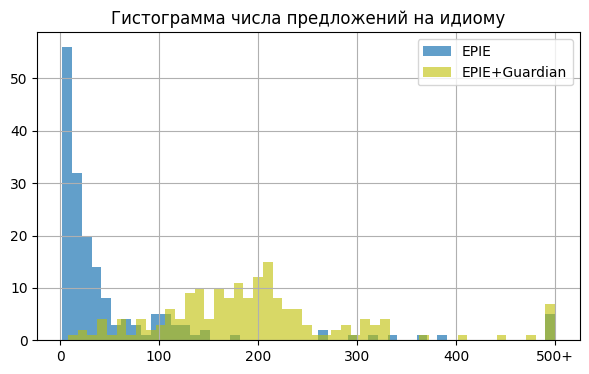

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

df_plot.hist(bins=50, label='EPIE', ax=ax, alpha=0.7)
df_plot1.hist(bins=50, label='EPIE+Guardian', ax=ax, alpha=0.6, color='y')
ticks = ax.get_xticklabels()
ticks[-2].set_text('500+')
# print(ticks)
ax.set_xticklabels([t._text for t in ticks])
plt.title('Гистограмма числа предложений на идиому')
plt.legend()
plt.show()

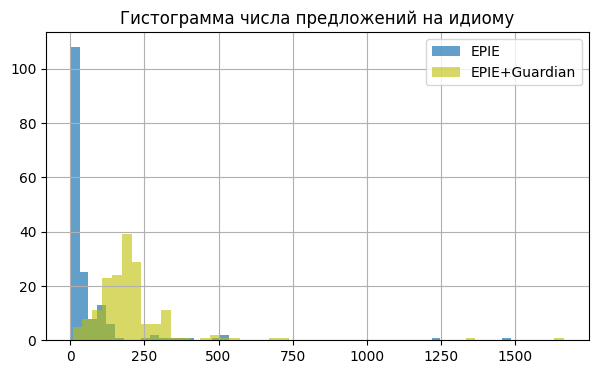

In [ ]:
ax = pd.concat([X_train, y_train], axis=1).groupby('idiom_label').agg({'sentence': 'count'}).hist(bins=50, figsize=(7, 4), 
                                                                                                  label='EPIE', alpha=0.7)
train_df_new.groupby('idiom_label').agg({'sentence': 'count'}).hist(bins=50, label='EPIE+Guardian', 
                                                                    ax=ax, alpha=0.6, color='y')
plt.title('Гистограмма числа предложений на идиому')
plt.legend()
plt.show()

In [32]:
# X_new, y_new = train_df_new.drop('idiom_label', axis=1), train_df_new.idiom_label
train_df_new1, dev_df_new = train_test_split(train_df_new, test_size=0.1,
                                             stratify=train_df_new.idiom_label, random_state=42)

In [ ]:
# dev_df_new.groupby('idiom_label').agg({'sentence': 'count'}).sort_values('sentence').min()

In [ ]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'sentence-transformers/all-distilroberta-v1' # 'bert-base-uncased' sys.argv[1] if len(sys.argv) > 1 else 'bert-base-uncased'

# Read the dataset
train_batch_size = 16

In [ ]:
model_save_path = 'output/training_' + model_name.replace("/", "-") # + '-' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
train_samples = []
unrep_dict = {}

for i in tqdm(range(len(train_df_new1))):
    np.random.seed(i)
    row = train_df_new1.iloc[i]
    true_idiom = row.idiom_label
    sent1 = row.sentence  #.replace(true_idiom, '')
    if len(sent1.replace(true_idiom, '').split()) >= 5:
        if len(train_df_new1[train_df_new1.idiom_label == true_idiom]) > 3:
            sent2_pos = np.random.choice(train_df_new1[(train_df_new1.idiom_label == true_idiom) & \
                                                      (train_df_new1.sentence != sent1)].sentence, size=1)[0]
            while (sent2_pos in unrep_dict) and (sent1 == unrep_dict[sent2_pos]):
                sent2_pos = np.random.choice(train_df_new1[(train_df_new1.idiom_label == true_idiom) & \
                                                          (train_df_new1.sentence != sent1)].sentence, size=1)[0]
        else:
            sent2_pos = np.random.choice(train_df_new1[(train_df_new1.idiom_label == true_idiom) & \
                                                      (train_df_new1.sentence != sent1)].sentence, size=1)[0]
        unrep_dict[sent1] = sent2_pos
        train_samples.append(InputExample(texts=[sent1.replace(true_idiom, ''), sent2_pos], label=1))

        sent2_neg = np.random.choice(train_df_new1[train_df_new1.idiom_label != true_idiom].sentence, size=1)[0]
        train_samples.append(InputExample(texts=[sent1.replace(true_idiom, ''), sent2_neg], label=0))

100%|██████████| 32845/32845 [06:15<00:00, 87.56it/s]


In [ ]:
len(train_samples)

63388

In [ ]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.SoftmaxLoss(model=model, 
                                sentence_embedding_dimension=model.get_sentence_embedding_dimension(), 
                                num_labels=2)

In [ ]:
# test_df_new = pd.DataFrame({'idiom_label': y_test, 'sentence': X_test})

In [ ]:
dev_samples = []
unrep_dict1 = {}

for i in tqdm(range(len(dev_df_new))):
    np.random.seed(i)
    row = dev_df_new.iloc[i]
    true_idiom = row.idiom_label
    sent1 = row.sentence  #.replace(true_idiom, '')
    if len(dev_df_new[dev_df_new.idiom_label == true_idiom]) > 3:
        sent2_pos = np.random.choice(dev_df_new[(dev_df_new.idiom_label == true_idiom) & \
                                                (dev_df_new.sentence != sent1)].sentence, size=1)[0]
        while (sent2_pos in unrep_dict1) and (sent1 == unrep_dict1[sent2_pos]):
            sent2_pos = np.random.choice(dev_df_new[(dev_df_new.idiom_label == true_idiom) & \
                                                    (dev_df_new.sentence != sent1)].sentence, size=1)[0]
    elif 1 < len(dev_df_new[dev_df_new.idiom_label == true_idiom]) <= 3:
        sent2_pos = np.random.choice(dev_df_new[(dev_df_new.idiom_label == true_idiom) & \
                                                (dev_df_new.sentence != sent1)].sentence, size=1)[0]
    try:
        unrep_dict1[sent1] = sent2_pos
        dev_samples.append(InputExample(texts=[sent1.replace(true_idiom, ''), sent2_pos], label=1))
    except:
      pass

    sent2_neg = np.random.choice(dev_df_new[dev_df_new.idiom_label != true_idiom].sentence, size=1)[0]
    dev_samples.append(InputExample(texts=[sent1.replace(true_idiom, ''), sent2_neg], label=0))

100%|██████████| 3650/3650 [00:12<00:00, 285.22it/s]


In [34]:
len(dev_samples)

7300

In [ ]:
dev_evaluator = BinaryClassificationEvaluator.from_input_examples(dev_samples,
                                                                  batch_size=train_batch_size, 
                                                                  name='sts-dev')

# Configure the training
num_epochs = 3

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.05) #10% of train data for warm-up

In [ ]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=dev_evaluator,
          epochs=num_epochs,
          evaluation_steps=300,
          warmup_steps=warmup_steps,
          output_path=model_save_path
          )

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

In [ ]:
sns.set_style('darkgrid')

In [ ]:
def plt_eval_res(csv_path):
    eval_df = pd.read_csv(csv_path)
    eval_acc_logs = eval_df[['epoch', 'steps', 'cossim_accuracy']].copy()
    eval_acc_logs.loc[eval_acc_logs['steps'] == -1, 'steps'] = 3962
    eval_acc_logs['steps'] = eval_acc_logs['steps'] + eval_acc_logs['epoch'] * 3900 
    eval_acc_logs['epoch'] = eval_acc_logs['epoch'] + 1 
    fig = plt.figure(figsize=(8, 3))
    sns.lineplot(eval_acc_logs, x='steps', y='cossim_accuracy', 
                hue='epoch', palette=sns.color_palette("bright", eval_acc_logs.epoch.max()))
    plt.title('Eval logs')
    plt.show()

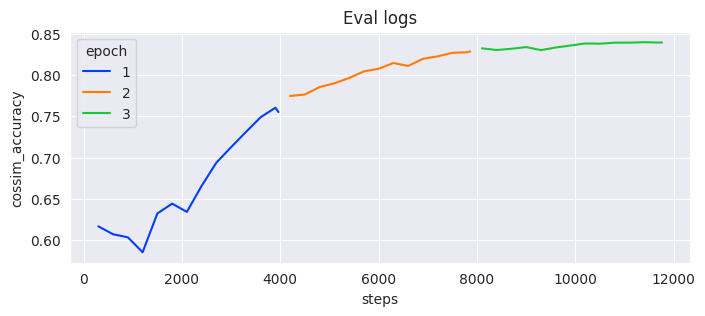

In [ ]:
plt_eval_res(csv_path=os.path.join(drive_data_dir, 
                                   'trained_sbert/eval/binary_classification_evaluation_sts-dev_results.csv'))

In [ ]:
dev_evaluator = BinaryClassificationEvaluator.from_input_examples(dev_samples,
                                                                  batch_size=train_batch_size, 
                                                                  name='sts-dev')

# Configure the training
num_epochs = 5

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.05) #10% of train data for warm-up

In [ ]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=dev_evaluator,
          epochs=num_epochs,
          evaluation_steps=300,
          warmup_steps=warmup_steps,
          output_path=model_save_path
          )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3962 [00:00<?, ?it/s]

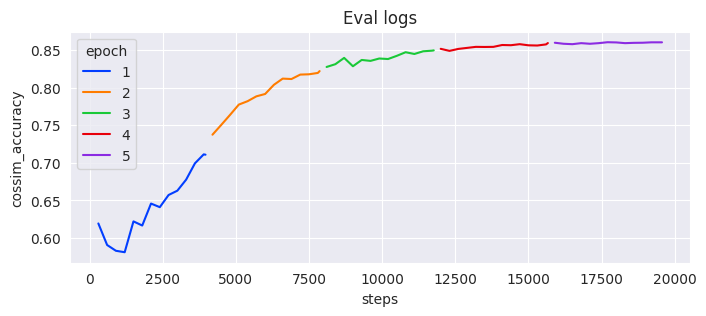

In [ ]:
plt_eval_res(csv_path='output/training_sentence-transformers-all-distilroberta-v1/eval/binary_classification_evaluation_sts-dev_results.csv')

# Смотрим качество обученной модели

In [ ]:
# model = SentenceTransformer(model_save_path)
# для загрузки модели, обученной на 3-х эпохах использовать trained_sbert
model = SentenceTransformer(os.path.join(drive_data_dir, 'trained_sbert_5_epochs'))

In [ ]:
%%time
test_embeds = model.encode(X_test1.values)  # получим эмбеддинги для предложений из теста

CPU times: user 4.97 s, sys: 1.2 s, total: 6.17 s
Wall time: 13.5 s


In [ ]:
test_embeds = list(zip(y_test, test_embeds))

In [ ]:
%%time
corpus = X_train.values.squeeze(1)
corpus_embeds = model.encode(corpus)
corpus_targets = y_train.values

CPU times: user 12 s, sys: 122 ms, total: 12.1 s
Wall time: 15.3 s


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df['rr'] = rr
print('\nMRR для all-distilroberta-v1 (trained 3 epochs):', round(res_df['rr'].mean(), 4))

100%|██████████| 2735/2735 [01:09<00:00, 39.58it/s]


MRR для all-distilroberta-v1 (trained 3 epochs): 0.405


In [ ]:
rr = count_rr(corpus_embeds, corpus_targets, test_embeds)
res_df = pd.concat([X_test1, y_test], axis=1).rename(columns={0: 'sentence'})
res_df['rr'] = rr
print('\nMRR для all-distilroberta-v1 (trained 5 epochs):', round(res_df['rr'].mean(), 4))

100%|██████████| 2735/2735 [01:22<00:00, 33.24it/s]


MRR для all-distilroberta-v1 (trained 5 epochs): 0.4594


In [ ]:
group_res_df = res_df.groupby('idiom_label').agg({'rr': 'mean', 'sentence': 'count'}).sort_values('rr')
group_res_df.rename(columns={'rr': 'averaged rr',
                             'sentence': 'number of sentences'}, inplace=True)
group_res_df.head(15)

,averaged rr,number of sentences
idiom_label,,
icing on the cake,0.000094,1
the upper crust,0.000099,1
on the same page,0.000118,4
dressed up to the nines,0.000129,1
in the blink of an eye,0.000168,2
silver bullet,0.000256,1
under the wire,0.000256,1
skin and bones,0.000302,1
once in a blue moon,0.000328,2


In [ ]:
group_res_df.tail(15)

,averaged rr,number of sentences
idiom_label,,
way around,0.635814,62
dirty work,0.661867,12
rags to riches,0.667325,3
an arm and a leg,0.680582,6
along the lines,0.694546,78
under the weather,0.718182,5
on the table,0.725426,283
by and large,0.727118,73
a fly on the wall,0.750000,2


In [ ]:
# добавим инфу о количестве предложений (sentence_train),
# которые видела модель при обучении
info_df = pd.merge(group_res_df, 
                   train_df_new.groupby('idiom_label').count().rename(columns={'sentence': 'number of sentence (train)'}),
                   on='idiom_label')

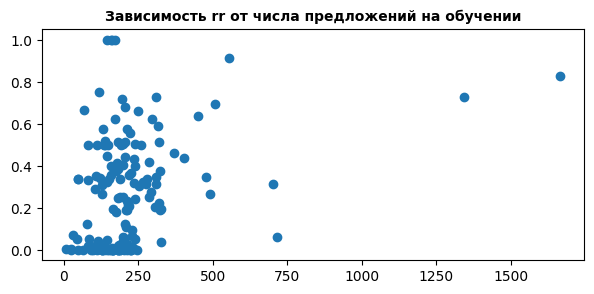

In [ ]:
fig = plt.figure(figsize=(7, 3))
plt.scatter(info_df['number of sentence (train)'], info_df['averaged rr'])
plt.title('Зависимость rr от числа предложений на обучении', weight='bold', fontsize=10)
plt.show()

In [ ]:
fig = px.scatter(group_res_df.reset_index(), x='sentence', 
                 y='rr', text='idiom_label')

fig.update_traces(textposition='top center')

fig.update_layout(
    autosize=False,
    height=600,
    width=900, 
    clickmode='select'
    # title_text=''
)
fig.show()

In [ ]:
group_res_df1 = res_df0.groupby('idiom_label').agg({'rr': 'mean', 'sentence': 'count'}).sort_values('rr')
group_res_df1.rename(columns={'rr': 'averaged rr',
                              'sentence': 'number of sentences'}, inplace=True)

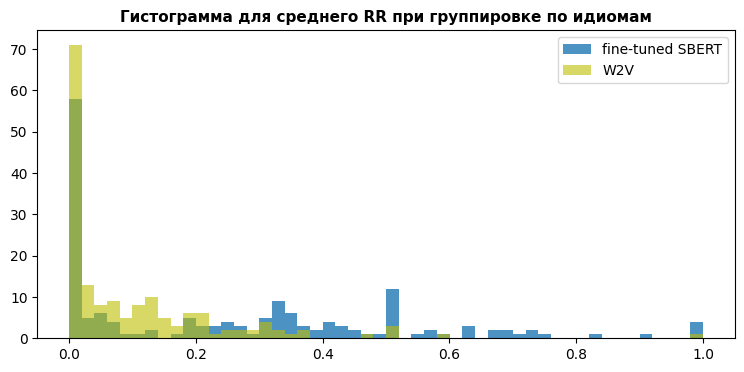

In [ ]:
fig = plt.figure(figsize=(9, 4))
plt.hist(group_res_df['averaged rr'], bins=50, alpha=0.8, label='fine-tuned SBERT')
plt.hist(group_res_df1['averaged rr'], bins=50, alpha=0.6, color='y', label='W2V')
plt.title('Гистограмма для среднего RR при группировке по идиомам', 
          weight='bold', fontsize=11)
plt.legend()
plt.show()

# Сохраняем дообученную модель на диск

In [ ]:
save_dir = os.path.join(drive_data_dir, 'trained_sbert_5_epochs')
os.makedirs(save_dir)

In [ ]:
from distutils.dir_util import copy_tree

# copy subdirectory example
from_directory = '/content/output/training_sentence-transformers-all-distilroberta-v1'

copy_tree(from_directory, save_dir)

['/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/eval/binary_classification_evaluation_sts-dev_results.csv',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/modules.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/tokenizer.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/config_sentence_transformers.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/config.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/sentence_bert_config.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_epochs/1_Pooling/config.json',
 '/content/drive/MyDrive/Colab Notebooks/vkr/trained_sbert_5_ep

In [ ]:
size = 0

Folderpath = '/content/output/training_sentence-transformers-all-distilroberta-v1'
 
for path, dirs, files in os.walk(Folderpath):
    for f in files:
        fp = os.path.join(path, f)
        size += os.path.getsize(fp)

print("Folder size:", size)

Folder size: 331904329
